/tmp/ipykernel_36934/354787418.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


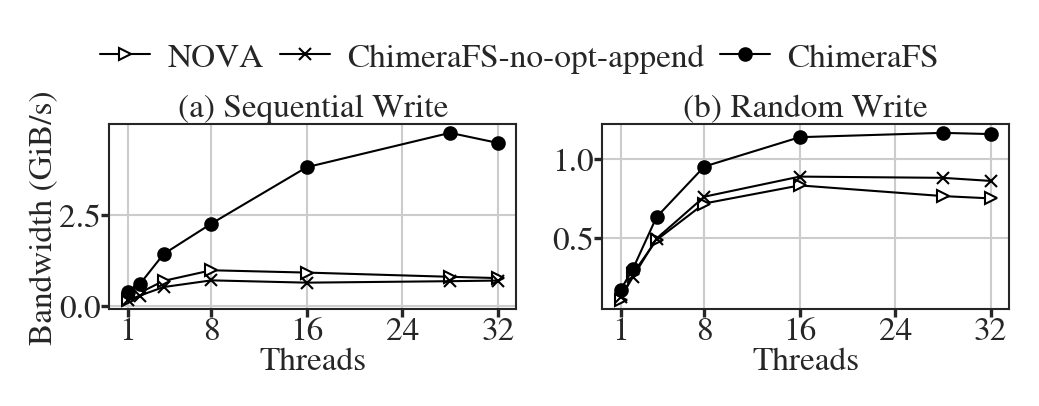

In [2]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-v0_8-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 8
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table-store", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(3)))

line_width = 0.5
# marks = [">", "x", "s", "D", "o", "o"]
marks = [">", "x", "o"]
fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
# fss = ["NOVA", "PMFS", "SplitFS-FIO", "MadFS", "EXT4-DAX", "SLOTFS"]
fss = ["nova", "parfs-no-opt-append-12", "parfs-12"]
# num_jobs = range(1, 17)  
num_jobs = [1, 2, 4, 8, 16, 28, 32]
x = list(num_jobs) 
ops = ["write", "randwrite"]
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024
titles = ["(a) Sequential Write", "(b) Random Write"]
lines = []

mapping = {
    "parfs-12":"ChimeraFS",
    "parfs-no-opt-append-12":"ChimeraFS-no-opt-append",
    "nova":"NOVA"
}
mapped_fss = [mapping.get(item, item) for item in fss]


for i in range(len(ops)):
    plt.subplot(1, 2, i + 1)
    op = ops[i]
    for idx, fs in enumerate(fss):
        y = df[(df['fs'] == fs) & (df['ops'] == op)]['bandwidth'].iloc[:len(num_jobs)]
        if fs == "parfs-12":
            markercoler = "black"
        else:
            markercoler = "white"
        
        if (len(x) != len(y)):
            print("Error: x and y lengths do not match")
            print(f"x: {x}, y: {y}")
            continue
        
        p, = plt.plot(x, y, color="black", markerfacecolor=markercoler, linewidth=line_width,label=fs, marker=marks[idx], markeredgecolor="black", markersize=3, markeredgewidth=0.5)
        #plt.scatter(x, y, color="white", s=0.3)
        lines.append(p)

    # if i == 3:
    #     plt.yticks([0, 2.0, 4.0, 6.0, 8.0])
    # else:
    #     plt.yticks([0, 0.6, 1.2, 1.8, 2.4])
    if i == 0 or i == 2:
        plt.ylabel('Bandwidth (GiB/s)', labelpad=-0.02)

    plt.title(titles[i], fontsize=8, pad=2)
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

    plt.xlabel("Threads", labelpad=-0.02) 
    # plt.xticks([1,4,8,12,16])
    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32])
    ax = plt.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

    plt.tick_params(axis='y', pad=0)
    plt.tick_params(axis='x', pad=0)

    ax = plt.gca()
    ax.tick_params(axis='y', which='major', length=2, direction='out', right=False, left=True)
    ax.tick_params(axis='x', which='major', length=2, direction='out', top=False, bottom=True)
    ax.yaxis.set_tick_params(which='major', size=2)
    
fig.legend(lines, mapped_fss, loc='center', bbox_to_anchor=(0.5, 1), ncol=6, columnspacing=0.5, handletextpad=0.5, handlelength=1.5, frameon=False)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.34, wspace=0.07)

plt.tight_layout()

plt.savefig("./FIO-OPT-APPEND.pdf", bbox_inches='tight', pad_inches=0.05)
